# Information Retrieval and Web Search
<p>
Course Project - Clustering documents to compress inverted index<br>
Giovanni Costa - 880892
</p>

In [1]:
import numpy as np
import multiprocessing
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_rcv1
from utils import random_search
from Indexer import Indexer

input_path="input/"
output_path="output/"
CORE_NUM=multiprocessing.cpu_count()
np.random.seed(42)

## Data fetching and index building

In [2]:
sparse_docs, _=fetch_rcv1(return_X_y=True) #TF-IDF matrix
sparse_docs=sparse_docs.astype("float32")
print(sparse_docs.shape)

(804414, 47236)


In [3]:
std_inverted_index=Indexer.get_dict_from_csr_matrix(sparse_docs) #build the inverted index from sparse matrix

## MiniBatch K-Means Method

In [4]:
n_iter=2
params_k_means={"n_clusters": [i for i in range(2, 104)]}
k_means_obj=MiniBatchKMeans(batch_size=512*CORE_NUM, n_init="auto") #For faster computations, you can set the batch_size greater than 256 * number of cores to enable parallelism on all cores

In [5]:
best_k_means, best_k_means_remapping, log_dict_k_means=random_search(k_means_obj, sparse_docs, std_inverted_index, params_k_means, n_iter, True)

Standard inverted index dimension: 12084.31 Bytes


 50%|█████     | 1/2 [01:33<01:33, 93.25s/it]

Improved avg postings dimension: 11759.829 Bytes ~1.3608 % reduction over the original


100%|██████████| 2/2 [03:20<00:00, 100.36s/it]

Improved avg postings dimension: 11598.965 Bytes ~2.0493 % reduction over the original
Best parameters: {'n_clusters': 47}
Best avg postings dimension:  11598.965 Bytes


## Gaussian Mixture method

In [ ]:
n_iter=25
params_mixture={"n_components": [i for i in range(2, 104)]}
mixture_obj=GaussianMixture(covariance_type="diag", init_params='k-means++')

In [ ]:
best_mixture, best_mixture_remapping, log_dict_mixture=random_search(mixture_obj, sparse_docs, std_inverted_index, params_mixture, n_iter, True)

## Results

### MiniBatch K-Means

In [6]:
params=np.array([elem["n_clusters"] for elem in log_dict_k_means["params"]])
tot_times=np.array(log_dict_k_means["tot_times"])
tsp_times=np.array(log_dict_k_means["tsp_times"])
std_index_size=log_dict_k_means["original_val"]
compressed_vals=np.array(log_dict_k_means["compressed_vals"])
params_index=np.argsort(params)
colors=sns.color_palette("pastel", n_colors=len(params))

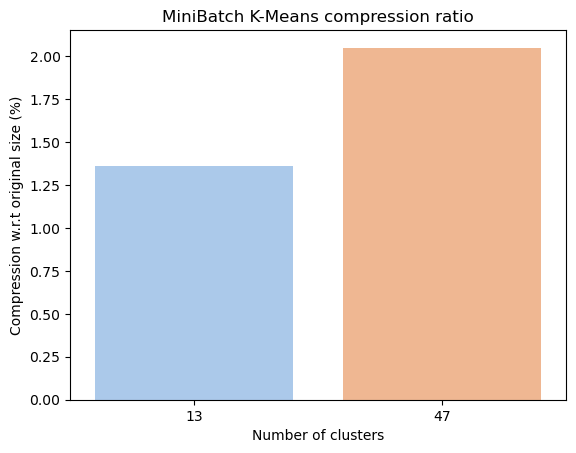

In [7]:
percentage_compr=np.round((((std_index_size-compressed_vals[params_index])/(std_index_size+compressed_vals[params_index]))*100), 4)
sns.barplot(x=params[params_index], y=percentage_compr, palette=colors)
plt.title('MiniBatch K-Means compression ratio')
plt.xlabel('Number of clusters')
plt.ylabel('Compression w.r.t original size (%)')
plt.show()

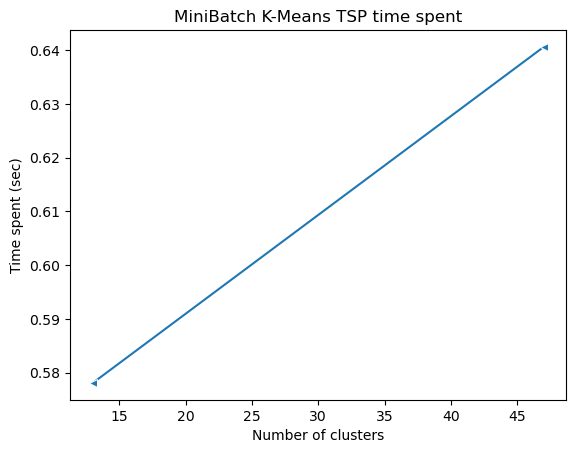

In [21]:
sns.lineplot(x=params[params_index], y=tsp_times[params_index], marker="<")
plt.title('MiniBatch K-Means TSP time spent')
plt.xlabel('Number of clusters')
plt.ylabel('Time spent (sec)')
plt.show()

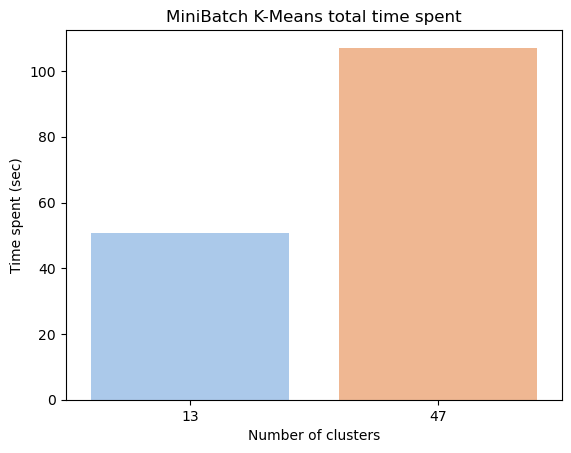

In [9]:
sns.barplot(x=params[params_index], y=tot_times[params_index], palette=colors)
plt.title('MiniBatch K-Means total time spent')
plt.xlabel('Number of clusters')
plt.ylabel('Time spent (sec)')
plt.show()

### Gaussian Mixture

In [ ]:
params=np.array([elem["n_components"] for elem in log_dict_mixture["params"]])
tot_times=np.array(log_dict_mixture["tot_times"])
tsp_times=np.array(log_dict_mixture["tsp_times"])
std_index_size=log_dict_mixture["original_val"]
compressed_vals=np.array(log_dict_mixture["compressed_vals"])
params_index=np.argsort(params)
colors=sns.color_palette("pastel", n_colors=len(params))

In [ ]:
percentage_compr=np.round((((std_index_size-compressed_vals[params_index])/(std_index_size+compressed_vals[params_index]))*100), 4)
sns.barplot(x=params[params_index], y=percentage_compr, palette=colors)
plt.title('Gaussian Mixture compression ratio')
plt.xlabel('Number of clusters')
plt.ylabel('Compression w.r.t original size (%)')
plt.show()

In [ ]:
sns.lineplot(x=params[params_index], y=tsp_times[params_index], marker="<")
plt.title('Gaussian Mixture TSP time spent')
plt.xlabel('Number of clusters')
plt.ylabel('Time spent (sec)')
plt.show()

In [ ]:
sns.barplot(x=params[params_index], y=tot_times[params_index], palette=colors)
plt.title('Gaussian Mixture total time spent')
plt.xlabel('Number of clusters')
plt.ylabel('Time spent (sec)')
plt.axhline(log_dict_k_means["lsa_time"]) #line that indicate the time spent by the LSA (in sec)
plt.show()